In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
sns.set_style('white')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from LB_D2Q9.dimensionless import opencl_dim as lb_cl
from LB_D2Q9.dimensionless import cython_dim as lb_cython
from LB_D2Q9.dimensionless import python_dim as lb_python

We now want to visualize the evolution of the flow...let's see how it goes...

In [7]:
from IPython import display

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [8]:
D = 1. # meter
rho = 1. # kg/m^3
nu = 1. # Viscosity, m^2/s

pressure_grad = -10 # Pa/m

pipe_length = 3*D # meter

# initialize cylinder
cylinder_center = [pipe_length/4, D/2]
cylinder_radius = D/10

sim_cl = lb_cl.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                             N=25, time_prefactor=1.,
                             cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                             two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
2d global: (768, 256)
2d local: (32, 32)
3d global: (768, 256, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192, 8192, 8192]
---------------------------
This context is associated with  1 devices
inlet rho: 1.09228288
outlet rho: 1.0


/home/bryan/anaconda/lib/python2.7/site-packages/pyopencl/__init__.py:59: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz' on 'Intel(R) OpenCL' at 0x3865fe8> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <update_feq> was successfully vectorized (8)
Kernel <update_hydro> was successfully vectorized (4)
Kernel <collide_particles> was successfully vectorized (4)
Kernel <copy_buffer> was successfully vectorized (4)
Kernel <move> was successfully vectorized (4)
Kernel <move_bcs> was successfully vectorized (4)
Kernel <move_bcs_PeriodicBC_VelocityInlet> was successfully vectorized (4)
Kernel <update_hydro_PeriodicBC_VelocityInlet> was successfully vectorized (4)
Kernel <set_zero_velocity_in_obstacle> was successfully vectorized (4)
Kernel <bounceback_in_obstacle> was not vectorized
Done.
  warn

In [9]:
sim_cython = lb_cython.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=25, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
inlet rho: 1.09228288
outlet rho: 1.0


In [10]:
sim_python = lb_python.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=25, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
omega 0.413223140496
inlet rho: 1.09228288
outlet rho: 1.0


In [11]:
sim_cl.run(100)

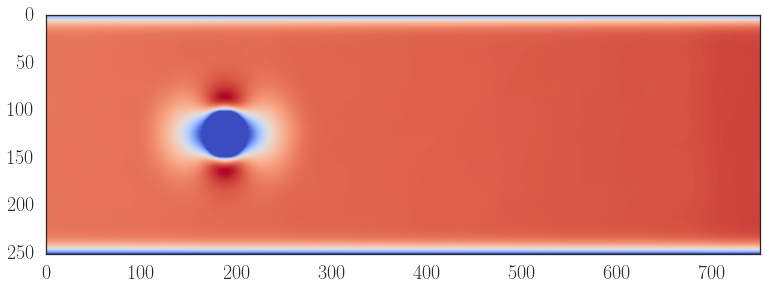

In [12]:
fields_cl = sim_cl.get_nondim_fields()
plt.imshow(fields_cl['u'].T, cmap=cm.coolwarm)

In [13]:
sim_cython.run(100)

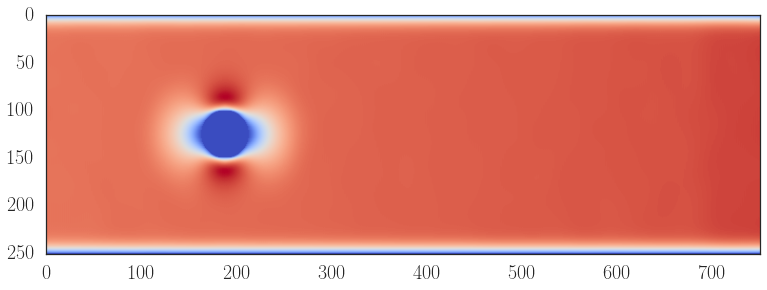

In [14]:
plt.imshow(sim_cython.u.T, cmap=cm.coolwarm)
plt.grid(False)

In [15]:
sim_python.run(100)

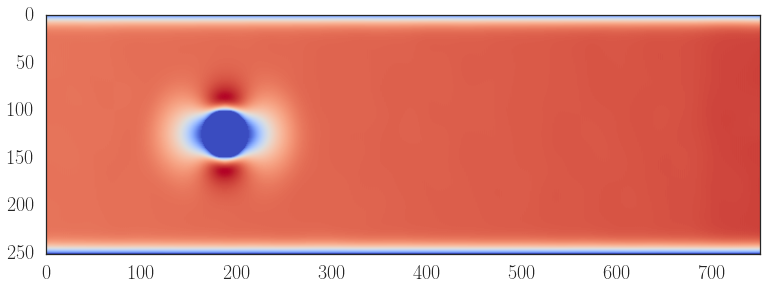

In [18]:
plt.imshow(sim_python.u.T, cmap=cm.coolwarm)
plt.grid(False)

All right! Great. We can now benchmark.